# Lab Assignment Four: Multi-Layer Perceptron 
Created by the **Dream Team:** Daniel Ryan, Josh Hascall, and Zach Suzuki

![DREAM TEAM!](g2.gif)

Dataset Description: https://www.kaggle.com/muonneutrino/us-census-demographic-data/data

**The classification task we will be performing is to predict, for each county, what the child poverty rate will be. We will need to convert this from regression to four levels of classification by quantizing the variable of interest.**

![We're going to fix poverty!](giphy.gif)

## Load, Split, and Balance

#### Load the data into memory and save it to a pandas data frame. Do not normalize or one-hot encode any of the features until asked to do so.  Remove any observations that having missing data. Encode any string data as integers for now (use label encoder). 

In [1]:
import pandas as pd
from sklearn import preprocessing 

#load
df = pd.read_csv("acs2017_census_tract_data.csv",index_col=0)
#drop all NA rows
df.dropna(inplace=True)

# Label encoding
label = preprocessing.LabelEncoder() 
df['State']= label.fit_transform(df['State']) 
df['County'] = label.fit_transform(df['County'])

####  Balance the dataset so that about the same number of instances are within each class. Choose a method for balancing the dataset and explain your reasoning for selecting this method. One option is to choose quantization thresholds for the "ChildPoverty" variable that equally divide the data into four classes. Should balancing of the dataset be done for both the training and testing set? Explain.

*Note: You will need to one hot encode the target, but do not one hot encode the categorical data until instructed to do so in the lab.*

We first tried using quantization, which worked okay (~75% accuracy). The problem with this is that it's really not great because it doesn't do a good job of training on the most important data. We'd prefer to use a common-sense approach, but struggled with "evenly splitting" the data.

We ultimately decided to go with a common-sense split in combination with over sampling the training dataset in order to balance our data. This is because we want to predict meaningful classes, but we also want equal training on each class, even if the balance is uneven. After looking at the number of instances in each of our four classes, we decided that it would be appropriate to oversample class 2 and 3 (the 50%-75% and 75%-100% child poverty rate classes), since those have very few instances in comparison to the other two classes.

From a qualitative standpoint, we considered:
 1. 0-25% limited child poverty (upper income)
 2. 25-50% moderate child poverty (upper middle income)
 3. 50-75% high child poverty (lower income)
 4. 75-100% extreme child poverty (extremely low income)

 While we don't have the exact data to split this way, we believe that we are relatively in line with the census definitions for poverty: https://www.census.gov/topics/income-poverty/poverty/guidance/poverty-measures.html

In [3]:
df['ChildPoverty'] = pd.cut(df['ChildPoverty'],
                            [-1e6,25,50,75,1e6],
                            labels=[0,1,2,3])
df_grouped = df.groupby(by=['ChildPoverty']
print(df_grouped.count())
(df_grouped.describe())

              State  County  TotalPop    Men  Women  Hispanic  White  Black  \
ChildPoverty                                                                  
0             47825   47825     47825  47825  47825     47825  47825  47825   
1             18400   18400     18400  18400  18400     18400  18400  18400   
2              5635    5635      5635   5635   5635      5635   5635   5635   
3               858     858       858    858    858       858    858    858   

              Native  Asian  ...   Walk  OtherTransp  WorkAtHome  MeanCommute  \
ChildPoverty                 ...                                                
0              47825  47825  ...  47825        47825       47825        47825   
1              18400  18400  ...  18400        18400       18400        18400   
2               5635   5635  ...   5635         5635        5635         5635   
3                858    858  ...    858          858         858          858   

              Employed  PrivateWork  P

State                                                     \
                count       mean        std  min   25%   50%   75%   max   
ChildPoverty                                                               
0             47825.0  24.372044  15.078436  0.0  10.0  23.0  37.0  51.0   
1             18400.0  23.918967  15.268950  0.0   9.0  24.0  38.0  51.0   
2              5635.0  25.050222  14.860903  0.0  10.0  25.0  39.0  51.0   
3               858.0  26.949883  13.950105  0.0  14.0  32.0  39.0  50.0   

               County               ... FamilyWork       Unemployment  \
                count         mean  ...        75%   max        count   
ChildPoverty                        ...                                 
0             47825.0  1006.559226  ...        0.1  10.4      47825.0   
1             18400.0   987.443859  ...        0.0  22.3      18400.0   
2              5635.0   969.145697  ...        0.0  10.1       5635.0   
3               858.0   967.041958  ...        0.0   5.6        858.0   

                                                                    
                   mean        std  min     25%    50%   75%   max  
ChildPoverty                                                        
0              5.546637   3.172879  0.0   3.400   5.00   7.1  48.5  
1              9.033152   4.898680  0.0   5.600   8.10  11.5  56.5  
2             13.575936   7.335422  0.0   8.200  12.30  17.5  49.1  
3             20.283450  10.602575  0.0  12.425  19.25  26.4  62.8  

[4 rows x 280 columns]

Even though only 858 tracts belong in the extreme poverty category, we believe it is important to seperate them this way. Using oversampling should also enable us to train a model that can identify these tracts with the highest poverty rate.

We think it is important to oversample with this data split because finding extreme poverty is much more important than identifying low poverty. Although there is no business case, it's worth mentioning that we would like to know the most impoverished tracts so we can allocate resources more effectively.

#### Assume you are equally interested in the classification performance for each class in the dataset. Split the dataset into 80% for training and 20% for testing.

In [50]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2) #come back. Do we need to balance before or after?
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train) #here we are oversampling


#confirm size of split data
print("Train: ", "{:.1%}".format(len(X_train)/len(df)))
print("Test: ","{:.1%}".format(len(X_test)/len(df)))

Train:  210.3%
Test:  20.0%


Don't one hot encode the feature data. It will be encoded when it goes into the neural network

## Pre-processing

*There are a number of version of the two layer perceptron covered in class. When using the example two layer network from class be sure that you use: (1) vectorized computation, (2) mini-batching, (3) cross entropy loss, and (4) proper Glorot initialization, at a minimum.*  

Grab the one that's WAY later on in the notebooks. No need for momentum or learning rate reduction

#### [.5 points] Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Do not normalize or one-hot encode the data (not yet). Be sure that training converges by graphing the loss function versus the number of epochs.

In [6]:
#This dataset is loaded for testing purposes. It takes multiple minutes to run a few hundred Epochs with our current implementation
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np

dr = load_digits()
Xr = dr.data/16.0-0.5 # normalize the input, very important
yr = dr.target



from sklearn.model_selection import train_test_split

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    Xr,yr,test_size = 0.2)

print(Xr_train.shape)
print(yr_train.shape)
print(Xr_test.shape)
print(yr_test.shape)

(1437, 64)
(1437,)
(360, 64)
(360,)


In [7]:
import numpy as np
from scipy.special import expit
import pandas as pd
import sys
from sklearn.metrics import accuracy_score


class TwoLayerPerceptronBase(object):
    def __init__(self, shuffle=True, minibatches=1,
                    n_hidden=30, C=0.0, epochs=500, eta=0.001, random_state=None):

        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatches = minibatches

    @staticmethod
    def _encode_labels(y):
        # Encode labels into one-hot representation
        onehot = pd.get_dummies(y).to_numpy().T
        return onehot

    def _initialize_weights(self):
        # initialize weights using Glorot implementation
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))

        # reduce the final layer magnitude in order to balance the size of the gradientes between
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 

        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    @staticmethod
    def _sigmoid(z):
        # Use scipy.expit to avoid overflow
        return expit(z) # 1/(1+np.exp(-z))

    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        # Compute L2-regularization cost
        # only for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))

    def _cost(self, A3, Y_enc, W1, W2):
        # get objective function value
        # cost = np.mean((Y_enc-A3)**2) # <- orignal cost function
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term

In [8]:
# feedforward
# fit and predict
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2, b1, b2):
        """ feedforward step:
        X: input layer with original features
        W1: Weight matrix for input layer -> hidden layer
        W2: Weight matrix for hidden layer -> output layer

        a1-a3: activations into layer (or output layer)
        z1-z2: layer inputs
        """

        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)

        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        # compute gradient using backpropagation
        # vectorized backpropagation
        # V is just here to separate the gradient equation for convenience
        V2 = (A3-Y_enc) # updated for cross entropy 
        
        V1 = A2*(1-A2)*(W2.T @ V2) # gradient for 2nd layer is determined before first

        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))

        #regularize weights, not bias
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2

    def predict(self, X):
        # predict class labels
        if type(X) != np.ndarray:
            X = X.to_numpy()
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False, XY_test=None):
        # learn weights from training data
        X_data, y_data = X.copy(), y.copy()
        if type(X) != np.ndarray:
            X_data, y_data = X_data.to_numpy(), y_data.to_numpy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()  #initialize weights with random values

        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)

        mean_1 = []
        mean_2 = []

        self.cost_ = []
        
        # adding support for keeping of validation in training loop
        # add in a calculation to test validation loss and accuracy at the end of each epoch
        self.score_ = [] 
        self.score_.append(accuracy_score(y_data, self.predict(X_data))) # get starting accuracy
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test, self.predict(X_test)))
            self.val_cost_ = []


        for i in range(self.epochs):
            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpochs: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:,idx_shuffle], y_data[idx_shuffle]

            # Use numpy split to split into equal sized batches
            # num batches == self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:
                # feedforward

                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx], self.W1, self.W2, self.b1, self.b2)

                cost = self._cost(A3, Y_enc[:, idx], self.W1, self.W2)
                mini_cost.append(cost) # appends cost of mini-batch only
                #compute gradient via backpropagation
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                Y_enc=Y_enc[:, idx], W1=self.W1, W2=self.W2)

                mean_1.append(np.mean(gradW1))
                mean_2.append(np.mean(gradW2))

                self.W1 -= self.eta * gradW1
                self.W2 -= self.eta * gradW2
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2

            self.grad_w1_[i] = np.mean(mean_1)
            self.grad_w2_[i] = np.mean(mean_2)

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data, self.predict(X_data)))
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
        
        return self

In [51]:
%%time
nn = TwoLayerPerceptron(n_hidden=30, 
                        C=0.01, # l2 regularization term
                        epochs=100, # number of runthroughs 
                        eta=0.001, #initial learning rate/step size
                        random_state=1,
                        minibatches=len(X_train)/125, # minibatch size
                        shuffle=True)


nn.fit(X_train, y_train, print_progress=10,XY_test=(X_test,y_test))
y_hat = nn.predict(X_test)
print('\nAccuracy:', accuracy_score(y_test, y_hat))

Epochs: 100/100
Accuracy: 0.07748899889988999
CPU times: user 1min 19s, sys: 17.9 s, total: 1min 37s
Wall time: 2min 48s


Yikes! That's terrible! Let's graph it out and see if we can explain what's happening here

In [10]:
# plot loss function vs epochs
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def print_result(nn,X_train,y_train,X_test,y_test,title="",color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))

    
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)

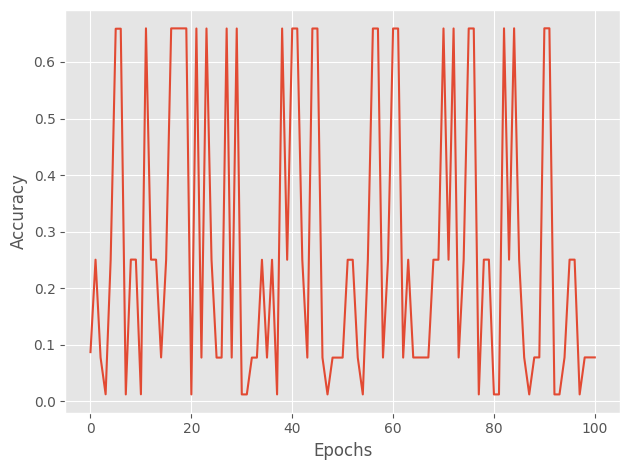

In [52]:
plt.plot(nn.val_score_)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

It looks like our NN is just jumping between classes and basically learning nothing. Does our loss function reduce at least? It's ok if it doesn't flatten out.

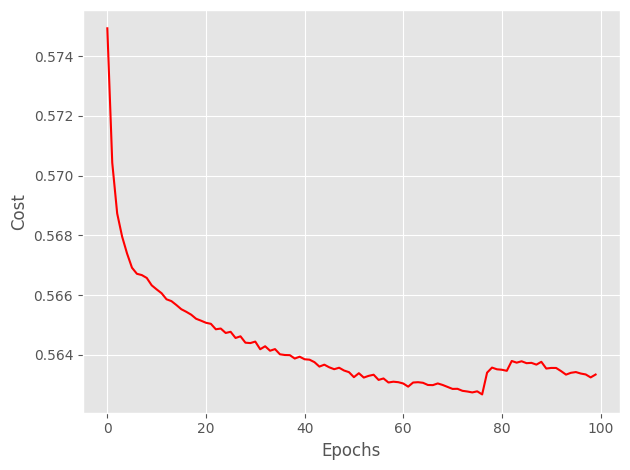

In [53]:
# cost vs epochs
cost_avgs = [np.mean(x) for x in nn.cost_]

plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()


Cost function seems to be reducing rather nicely, although quite bumpy and it randomly JUMPS up! Not sure exactly why this is happening, but perhaps our data needs to be normalized...

#### Now normalize the continuous numeric feature data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs. 

In [13]:
from sklearn.preprocessing import MinMaxScaler

X_cat = X[['State', 'County']]
X.drop(['State','County'],inplace=True,axis=1)

scaler = MinMaxScaler()
scaler.fit(X)
scaled = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled, columns=X.columns)
scaled_df.join(X_cat)

X_train, X_test, y_train, y_test = train_test_split(scaled_df,y, test_size=0.2)


In [14]:
%%time

nn.fit(X_train, y_train, print_progress=50,XY_test=(X_test,y_test))
y_hat2 = nn.predict(X_test)
print('\nAccuracy:', accuracy_score(y_test, y_hat2))

Epochs: 100/100
Accuracy: 0.8461908690869087
CPU times: user 56.5 s, sys: 12.6 s, total: 1min 9s
Wall time: 1min 57s


Very high accuracy and in less than two minutes! We're quite satisfied with this. Let's investigate further

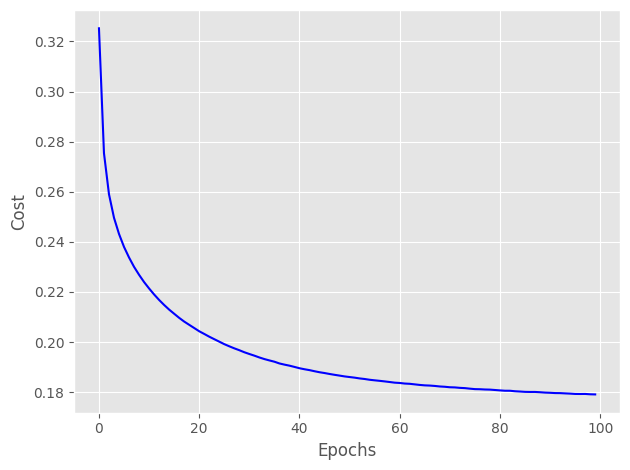

In [17]:
# plot cost vs epochs
cost_avgs2 = [np.mean(x) for x in nn.cost_]

plt.plot(range(len(cost_avgs)), cost_avgs2, color='blue')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

This cost function appears to be reducing very nicely!

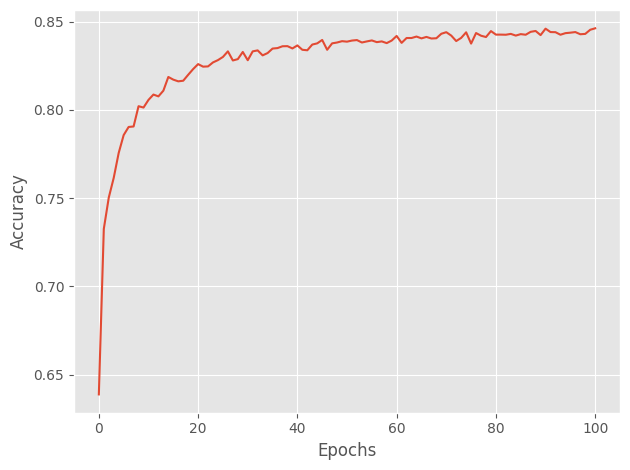

In [18]:
vs2 = nn.val_score_
plt.plot(vs2)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

Accuracy also looks very good! While we probably could have run another hundred Epochs, it's clear that the NN is working!

Will OHE improve our accuracy further?

#### Now normalize the continuous numeric feature data AND one hot encode the categorical data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs. 

In [19]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoded_data = pd.get_dummies(X_cat, columns = ['State']).copy(deep=True) #decided not to add county. Didn't seem to make a difference in testing
scaled_df = pd.DataFrame(scaled, columns=X.columns)
ind = X.index
scaled_df['ind'] = ind
scaled_df.set_index('ind', inplace=True)
scaled_df = scaled_df.join(one_hot_encoded_data.drop('County',axis=1))

X_train, X_test, y_train, y_test = train_test_split(scaled_df,y, test_size=0.2)

In [21]:
%%time
# run neural network

nn.fit(X_train, y_train, print_progress=50,XY_test=(X_test,y_test))
y_hat3 = nn.predict(X_test)
print('\nAccuracy:', accuracy_score(y_test, y_hat3))

Epochs: 100/100
Accuracy: 0.8473597359735974
CPU times: user 1min 2s, sys: 14.9 s, total: 1min 17s
Wall time: 2min 11s


0.1% better!! Is this statistically signifigant?? Probably not. We'll investigate below. One thing that is interesting was the longer run time; was the marginal increase in accuracy worth the 20 second increase in time?

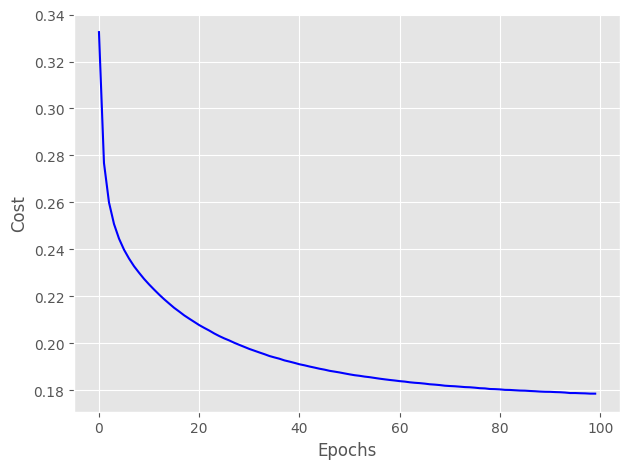

In [23]:
# plot cost vs epochs
cost_avgs3 = [np.mean(x) for x in nn.cost_]

plt.plot(range(len(cost_avgs)), cost_avgs3, color='blue')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

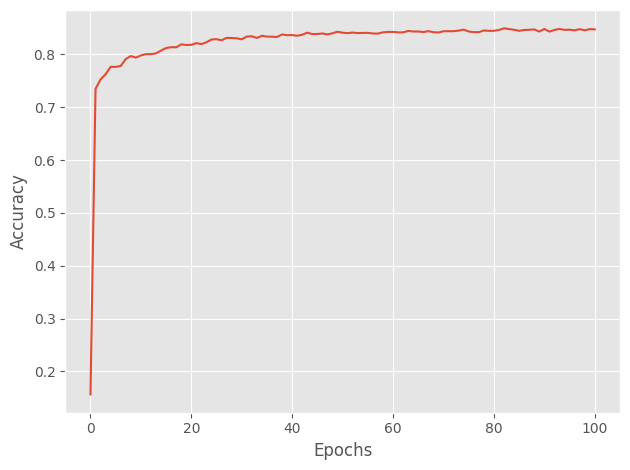

In [24]:
vs3 = nn.val_score_
plt.plot(vs3)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

These charts appear much smoother than without the OHE. Very interesting result.

#### Compare the performance of the three models you just trained. Are there any meaningful differences in performance? Explain, in your own words, why these models have (or do not have) different performances.  

First, out of morbid curiousity, let's compare to SKlearn. Just going to pull directly from one of the in class notebooks, so it may not be a fair 1-1 comparison:

In [22]:
from sklearn import __version__ as sklearn_version
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

print(sklearn_version)
# these values have been hand tuned
clf = MLPClassifier(hidden_layer_sizes=(50, ), 
                    activation='logistic', # compare to sigmoid
                    solver='sgd', 
                    alpha=1e-4, # L2 penalty
                    batch_size=128, # min of 200, num_samples
                    learning_rate='adaptive', # decrease rate if loss goes up
                    learning_rate_init=0.1, # only SGD
                    power_t=0.5,    # only SGD with inverse scaling
                    max_iter=75, 
                    shuffle=True, 
                    random_state=1, 
                    tol=1e-9, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=True, # only SGD
                    early_stopping=False, 
                    validation_fraction=0.1, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

%time clf.fit(X_train,y_train)
yhat = clf.predict(X_test)
print('Validation Acc:',accuracy_score(yhat,y_test))

1.1.2
CPU times: user 21.6 s, sys: 218 µs, total: 21.6 s
Wall time: 43.8 s
Validation Acc: 0.8673679867986799
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (75) reached and the optimization hasn't converged yet.
  warnings.warn(


2% better and substantially faster! We believe our repeated matrix multiplication is making our result much slower, but for the purposes of this implementation, we are statisfied with our performance at this point. Perhaps our Multi-layer networks can beat out SKL on at least accuracy!

First, let's look at the first model and see what it did:

In [58]:
y_hat

array([2, 2, 2, ..., 2, 2, 2])

In [59]:
pd.crosstab(y_hat, y_test,
                            margins=True, margins_name="Total")

ChildPoverty,0,1,2,3,Total
row_0,,,,,
2,9589,3638,1123,171,14521
3,6,5,8,4,23
Total,9595,3643,1131,175,14544


Looks like all it did was guess 2 and 3 a couple times. How about models 2 and 3?

In [60]:
pd.crosstab(y_hat2, y_test,
                            margins=True, margins_name="Total")

ChildPoverty,0,1,2,3,Total
row_0,,,,,
0,6493,2414,751,113,9771
1,2484,968,314,46,3812
2,612,259,65,16,952
3,6,2,1,0,9
Total,9595,3643,1131,175,14544


In [61]:
pd.crosstab(y_hat3, y_test,
                            margins=True, margins_name="Total")

ChildPoverty,0,1,2,3,Total
row_0,,,,,
0,6445,2462,756,129,9792
1,2600,968,303,39,3910
2,541,209,70,7,827
3,9,4,2,0,15
Total,9595,3643,1131,175,14544


Even though we overfitted our data to bias extreme poverty, all our models failed to identify extreme poverty most of the time. Very interesting, not sure the exact explanation for this

Let's ask the question. Is there a meaningful difference in performance between the three models? Let's see if the second and third model are statistically different from one another. We're going to use mcnemar statistical tests

In [62]:
#kachow 
from statsmodels.stats.contingency_tables import mcnemar

data_crosstab = pd.crosstab(y_hat3, y_hat2,
                            margins=True, margins_name="Total")

print(mcnemar(data_crosstab, exact=False))

pvalue      0.40242402946578093
statistic   0.7010710808179162


What this means to us is that the difference between the performance of the models is not statistically signifigant. Even though the accuracy of model3 (one hot encoded), is slightly higher than model2, it could have just been a fluke. Even though there is minimal difference between the models, we will retain the OHE version going forward (because you told us to).

In [65]:
data_crosstab = pd.crosstab(yhat, y_hat3,
                            margins=True, margins_name="Total")
data_crosstab

print(mcnemar(data_crosstab, exact=False))

pvalue      5.6696511455642535e-18
statistic   74.63269230769231


This seems to show that SKL is statistically different in its execution to the third model. Let's examine a little more:

In [66]:
data_crosstab

col_0,0,1,2,3,Total
row_0,,,,,
0,9433,161,28,1,9623
1,359,3454,31,0,3844
2,0,294,660,0,954
3,0,1,108,14,123
Total,9792,3910,827,15,14544


In [71]:
data_crosstab = pd.crosstab(yhat, y_test,
                            margins=True, margins_name="Total")
data_crosstab

ChildPoverty,0,1,2,3,Total
row_0,,,,,
0,6345,2409,742,127,9623
1,2535,967,302,40,3844
2,636,237,74,7,954
3,79,30,13,1,123
Total,9595,3643,1131,175,14544


SKL is much better at predicting extreme poverty than our implementation.

#### Why is the performance different?

First, with the first model, we believe that the model has an extremely hard time understanding data that is not normalized.

For the second model, this is the biggest improvement in performance, and normalizing everything (but categorical data), allows the model to digest and interpret the instances and learn. The loss function becoming much smoother is clear evidence of this.

As we discussed and proved above, there is no statistically different performance between the second and the third model. We are a little confused by this because our intuition says that some states should have higher child poverty rates on their own. Our best guess is that we would need to run on substantially more epochs before the model can fully digest and interpret this additional data. We saw the loss functions for both models still not flat, so it's possible with more time they could have had statistically different dispersion in performance

It is worth noting that the time to run these models is extremely poor. We beleive our implementations are correct, but this could and should be optimized down the line.

*Use one-hot encoding and normalization on the dataset for the remainder of this lab assignment.*

## Modeling 

#### Add support for a third layer in the multi-layer perceptron. Add support for saving (and plotting after training is completed) the average magnitude of the gradient for each layer, for each epoch (like we did in the flipped module for back propagation). For magnitude calculation, you are free to use either the average absolute values or the L1/L2 norm.

Since our 2 layer perceptron worked so well, lets add support for a third layer! We will simply add a set of weights and biases for an additional feedforward and gradient calculation.

In [27]:
class ThreeLayerPerceptron(TwoLayerPerceptronBase):
    def __init__(self, n_hidden2=20, **kwds):        
        # need to add to the original initializer 
        self.n_hidden2 = n_hidden2
        # but keep other keywords
        super().__init__(**kwds)
    
    def _initialize_weights(self):
        # initialize weights using Glorot implementation
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))

        init_bound = 4*np.sqrt(6. / (self.n_hidden2 + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden2, self.n_hidden))
        
        # reduce the final layer magnitude in order to balance the size of the gradientes between
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden2))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden2)) 

        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_hidden2, 1))
        b3 = np.zeros((self.n_output_, 1))
        
        return W1, W2, W3, b1, b2, b3

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3):
        # Compute L2-regularization cost
        # only for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:]**2))

    def _cost(self, A4, Y_enc, W1, W2, W3):
        # get objective function value
        # cost = np.mean((Y_enc-A3)**2) # <- orignal cost function
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A4)+(1-Y_enc)*np.log(1-A4))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term

    def _feedforward(self, X, W1, W2, W3, b1, b2, b3):
        """ feedforward step:
        X: input layer with original features
        W1: Weight matrix for input layer -> hidden layer
        W2: Weight matrix for hidden layer1 -> hidden layer2
        W3: Weight matrix for hidden layer2 -> output layer

        a1-a3: activations into layer (or output layer)
        z1-z3: layer inputs
        """

        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)

        return A1, Z1, A2, Z2, A3, Z3, A4
    
    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        # compute gradient using backpropagation
        # vectorized backpropagation
        # V is just here to separate the gradient equation for convenience
        
        V3 = (A4-Y_enc)
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)
#         V2 = (A3-Y_enc) # updated for cross entropy 
#         V1 = A2*(1-A2)*(W2.T @ V2) # gradient for 2nd layer is determined before first
        
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))

        #regularize weights, not bias
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C

        return gradW1, gradW2, gradW3, gradb1, gradb2, gradb3

    def predict(self, X):
        # predict class labels
        if type(X) != np.ndarray:
            X = X.to_numpy()
        _, _, _, _, _, _, A4 = self._feedforward(X, self.W1, self.W2, self.W3, self.b1, self.b2, self.b3)
        y_pred = np.argmax(A4, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False, XY_test=None):
        # learn weights from training data
        X_data, y_data = X.copy(), y.copy()
        if type(X) != np.ndarray:
            X_data, y_data = X_data.to_numpy(), y_data.to_numpy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.b1, self.b2, self.b3 = self._initialize_weights()  #initialize weights with random values

        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        
        mean_1 = []
        mean_2 = []
        mean_3 = []
        
        self.cost_ = []
        
        # adding support for keeping of validation in training loop
        # add in a calculation to test validation loss and accuracy at the end of each epoch
        self.score_ = [] 
        self.score_.append(accuracy_score(y_data, self.predict(X_data))) # get starting accuracy
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test, self.predict(X_test)))
            self.val_cost_ = []


        for i in range(self.epochs):
            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpochs: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:,idx_shuffle], y_data[idx_shuffle]

            # Use numpy split to split into equal sized batches
            # num batches == self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:
                # feedforward

                A1, Z1, A2, Z2, A3, Z3, A4 = self._feedforward(X_data[idx], self.W1, self.W2, self.W3, self.b1, self.b2, self.b3)

                cost = self._cost(A4, Y_enc[:, idx], self.W1, self.W2, self.W3)
                mini_cost.append(cost) # appends cost of mini-batch only
                #compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradb1, gradb2, gradb3 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, 
                                                                                    Z1=Z1, Z2=Z2, Z3=Z3,
                                                Y_enc=Y_enc[:, idx], W1=self.W1, W2=self.W2, W3=self.W3)
                
                
                mean_1.append(np.mean(gradW1))
                mean_2.append(np.mean(gradW2))
                mean_3.append(np.mean(gradW3))
                
                self.W1 -= self.eta * gradW1
                self.W2 -= self.eta * gradW2
                self.W3 -= self.eta * gradW3
                
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2
                self.b3 -= self.eta * gradb3

            self.grad_w1_[i] = np.mean(mean_1)
            self.grad_w2_[i] = np.mean(mean_2)
            self.grad_w3_[i] = np.mean(mean_3)
                
            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data, self.predict(X_data)))
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
        
        return self

In [30]:
%%time
nn = ThreeLayerPerceptron(n_hidden=50, 
                        n_hidden2=30,
                        C=0.01, # l2 regularization term
                        epochs=50, # number of runthroughs 
                        eta=0.001, #initial learning rate/step size
                        random_state=1,
                        minibatches=len(X_train)/125, # minibatch size
                        shuffle=True)


nn.fit(X_train, y_train, print_progress=25,XY_test=(X_test,y_test))
y_hat = nn.predict(X_test)
print('\nAccuracy:', accuracy_score(y_test, y_hat))

Epochs: 50/50
Accuracy: 0.8602172717271728
CPU times: user 1min 23s, sys: 1min 4s, total: 2min 27s
Wall time: 3min 17s


Yikes! It looks like the performance of the perceptron decreased! While the accuracy remained around the same, it took so much longer to run. However, with such a large amount of features and instances, it is not surprising that an additional layer of matrix multiplication would slow down the performance significantly.

To confirm our performance, here is our gradient vs. epoch graph, where we see the gradients all converge down. This is good and confirms that the gradient calculation is correct.

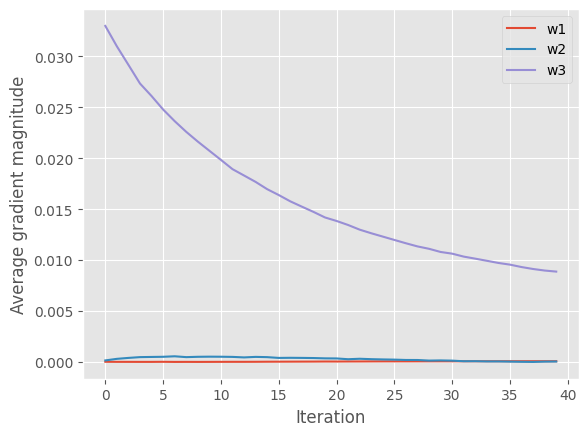

In [31]:
import matplotlib.pyplot as plt

ax = plt.subplot(1,1,1)
plt.plot(abs(nn.grad_w1_[10:]), label='w1')
plt.plot(abs(nn.grad_w2_[10:]), label='w2')
plt.plot(abs(nn.grad_w3_[10:]), label='w3')
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

#### Repeat the previous step, adding support for a fourth layer.

Since a 3rd layer increased the accuracy, lets add a 4th! We will continue with this strategy of manually adding more weights and biases to the feedforward and gradient calculation.

In [32]:
class FourLayerPerceptron(TwoLayerPerceptronBase):
    def __init__(self, n_hidden2=30, n_hidden3=25, **kwds):        
        # need to add to the original initializer 
        self.n_hidden2 = n_hidden2
        self.n_hidden3 = n_hidden3
        # but keep other keywords
        super().__init__(**kwds)
    
    def _initialize_weights(self):
        # initialize weights using Glorot implementation
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))

        init_bound = 4*np.sqrt(6. / (self.n_hidden2 + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden2, self.n_hidden))

        init_bound = 4*np.sqrt(6. / (self.n_hidden3 + self.n_hidden2))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden3, self.n_hidden2))
        
        # reduce the final layer magnitude in order to balance the size of the gradientes between
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden3))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden3)) 

        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_hidden2, 1))
        b3 = np.zeros((self.n_hidden3, 1))
        b4 = np.zeros((self.n_output_, 1))
        
        return W1, W2, W3, W4, b1, b2, b3, b4

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4):
        # Compute L2-regularization cost
        # only for non-bias terms
        means = np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:]**2) + np.mean(W4[:, 1:]**2)
        return (lambda_/2.0) * np.sqrt(means)

    def _cost(self, A5, Y_enc, W1, W2, W3, W4):
        # get objective function value
        # cost = np.mean((Y_enc-A3)**2) # <- orignal cost function
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A5)+(1-Y_enc)*np.log(1-A5))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4)
        return cost + L2_term

    def _feedforward(self, X, W1, W2, W3, W4, b1, b2, b3, b4):
        """ feedforward step:
        X: input layer with original features
        W1: Weight matrix for input layer -> hidden layer
        W2: Weight matrix for hidden layer1 -> hidden layer2
        W3: Weight matrix for hidden layer2 -> output layer

        a1-a3: activations into layer (or output layer)
        z1-z3: layer inputs
        """

        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        Z4 = W4 @ A4 + b4
        A5 = self._sigmoid(Z4)

        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5
    
    def _get_gradient(self, A1, A2, A3, A4, A5, Z1, Z2, Z3, Z4, Y_enc, W1, W2, W3, W4):
        # compute gradient using backpropagation
        # vectorized backpropagation
        # V is just here to separate the gradient equation for convenience
        
        V4 = (A5-Y_enc)
        V3 = A4*(1-A4)*(W4.T @ V4)
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)
#         V2 = (A3-Y_enc) # updated for cross entropy 
#         V1 = A2*(1-A2)*(W2.T @ V2) # gradient for 2nd layer is determined before first
        
        gradW4 = V4 @ A4.T
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb4 = np.sum(V4, axis=1).reshape((-1,1)) 
        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))

        #regularize weights, not bias
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C
        gradW4 += W4 * self.l2_C

        return gradW1, gradW2, gradW3, gradW4, gradb1, gradb2, gradb3, gradb4

    def predict(self, X):
        # predict class labels
        if type(X) != np.ndarray:
            X = X.to_numpy()
        _, _, _, _, _, _, _, _, A5 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4,
                                                        self.b1, self.b2, self.b3, self.b4)
        y_pred = np.argmax(A5, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False, XY_test=None):
        # learn weights from training data
        X_data, y_data = X.copy(), y.copy()
        if type(X) != np.ndarray:
            X_data, y_data = X_data.to_numpy(), y_data.to_numpy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4 = self._initialize_weights()  #initialize weights with random values

        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        self.grad_w4_ = np.zeros(self.epochs)
        
        mean_1 = []
        mean_2 = []
        mean_3 = []
        mean_4 = []
        
        self.cost_ = []
        
        # adding support for keeping of validation in training loop
        # add in a calculation to test validation loss and accuracy at the end of each epoch
        self.score_ = [] 
        self.score_.append(accuracy_score(y_data, self.predict(X_data))) # get starting accuracy
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test, self.predict(X_test)))
            self.val_cost_ = []


        for i in range(self.epochs):
            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpochs: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:,idx_shuffle], y_data[idx_shuffle]

            # Use numpy split to split into equal sized batches
            # num batches == self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:
                # feedforward

                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5 = self._feedforward(X_data[idx], 
                                                                       self.W1, self.W2, self.W3, self.W4,
                                                                       self.b1, self.b2, self.b3, self.b4)

                cost = self._cost(A5, Y_enc[:, idx], self.W1, self.W2, self.W3, self.W4)
                mini_cost.append(cost) # appends cost of mini-batch only
                #compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradW4, gradb1, gradb2, gradb3, gradb4= self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5,
                                                                                    Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4,
                                                Y_enc=Y_enc[:, idx], W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4)
                
                
                mean_1.append(np.mean(gradW1))
                mean_2.append(np.mean(gradW2))
                mean_3.append(np.mean(gradW3))
                mean_4.append(np.mean(gradW4))
                
                self.W1 -= self.eta * gradW1
                self.W2 -= self.eta * gradW2
                self.W3 -= self.eta * gradW3
                self.W4 -= self.eta * gradW4
                
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2
                self.b3 -= self.eta * gradb3
                self.b4 -= self.eta * gradb4

            self.grad_w1_[i] = np.mean(mean_1)
            self.grad_w2_[i] = np.mean(mean_2)
            self.grad_w3_[i] = np.mean(mean_3)
            self.grad_w4_[i] = np.mean(mean_4)
                
            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data, self.predict(X_data)))
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
        
        return self

In [33]:
%%time
nn = FourLayerPerceptron(n_hidden=50, 
                        n_hidden2=30,
                        n_hidden3=30,
                        C=0.01, # l2 regularization term
                        epochs=50, # number of runthroughs 
                        eta=0.001, #initial learning rate/step size
                        random_state=1,
                        minibatches=len(X_train)/125, # minibatch size
                        shuffle=True)


nn.fit(X_train, y_train, print_progress=25,XY_test=(X_test,y_test))
y_hat = nn.predict(X_test)
print('\nAccuracy:', accuracy_score(y_test, y_hat))

Epochs: 50/50
Accuracy: 0.8622799779977998
CPU times: user 1min 40s, sys: 1min 19s, total: 2min 59s
Wall time: 4min 2s


Great!... kinda. Although accuracy did increase, it was by a slight margin that would not be statistically impactful. Additionally, the 4th layer significantly slowed down the network. 

Following is the gradient vs. epochs graph, which confirms the convergence of the gradients as we run through the network more. This suggests that it might not hurt to run the four layer perceptron with more epochs.

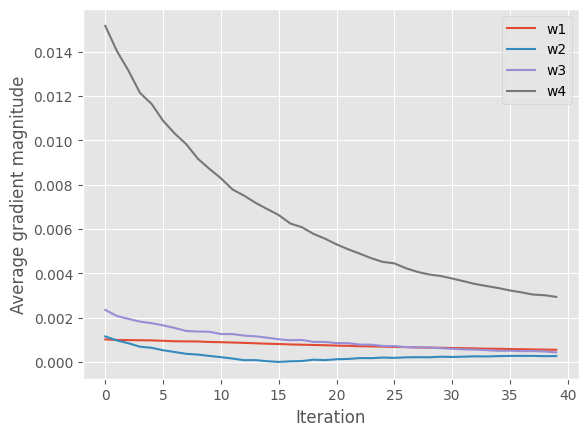

In [34]:
ax = plt.subplot(1,1,1)
plt.plot(abs(nn.grad_w1_[10:]), label='w1')
plt.plot(abs(nn.grad_w2_[10:]), label='w2')
plt.plot(abs(nn.grad_w3_[10:]), label='w3')
plt.plot(abs(nn.grad_w4_[10:]), label='w4')
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

#### Repeat the previous step, adding support for a fifth layer. 

To add more complexity to this already complex network, lets add an additional hidden layer. Here we will repeat the strategy for the last 2 iterations, by adding another set of weights and biases to the feedforward and gradient calculation.

In [35]:
class FiveLayerPerceptron(TwoLayerPerceptronBase):
    def __init__(self, n_hidden2=30, n_hidden3=25, n_hidden4=15, **kwds):        
        # need to add to the original initializer 
        self.n_hidden2 = n_hidden2
        self.n_hidden3 = n_hidden3
        self.n_hidden4 = n_hidden4
        # but keep other keywords
        super().__init__(**kwds)
    
    def _initialize_weights(self):
        # initialize weights using Glorot implementation
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))

        init_bound = 4*np.sqrt(6. / (self.n_hidden2 + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden2, self.n_hidden))

        init_bound = 4*np.sqrt(6. / (self.n_hidden3 + self.n_hidden2))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden3, self.n_hidden2))

        init_bound = 4*np.sqrt(6. / (self.n_hidden4 + self.n_hidden3))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_hidden4, self.n_hidden3))
        
        # reduce the final layer magnitude in order to balance the size of the gradientes between
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden4))
        W5 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden4)) 

        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_hidden2, 1))
        b3 = np.zeros((self.n_hidden3, 1))
        b4 = np.zeros((self.n_hidden4, 1))
        b5 = np.zeros((self.n_output_, 1))
        
        return W1, W2, W3, W4, W5, b1, b2, b3, b4, b5

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4, W5):
        # Compute L2-regularization cost
        # only for non-bias terms
        means = np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:]**2) + np.mean(W4[:, 1:]**2) + np.mean(W5[:, 1:]**2)
        return (lambda_/2.0) * np.sqrt(means)

    def _cost(self, A6, Y_enc, W1, W2, W3, W4, W5):
        # get objective function value
        # cost = np.mean((Y_enc-A3)**2) # <- orignal cost function
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A6)+(1-Y_enc)*np.log(1-A6))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term

    def _feedforward(self, X, W1, W2, W3, W4, W5, b1, b2, b3, b4, b5):
        """ feedforward step:
        X: input layer with original features
        W1: Weight matrix for input layer -> hidden layer
        W2: Weight matrix for hidden layer1 -> hidden layer2
        W3: Weight matrix for hidden layer2 -> output layer

        a1-a3: activations into layer (or output layer)
        z1-z3: layer inputs
        """

        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        Z4 = W4 @ A4 + b4
        A5 = self._sigmoid(Z4)
        Z5 = W5 @ A5 + b5
        A6 = self._sigmoid(Z5)

        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6
    
    def _get_gradient(self, A1, A2, A3, A4, A5, A6, Z1, Z2, Z3, Z4, Z5, Y_enc, W1, W2, W3, W4, W5):
        # compute gradient using backpropagation
        # vectorized backpropagation
        # V is just here to separate the gradient equation for convenience
        
        V5 = (A6-Y_enc)
        V4 = A5*(1-A5)*(W5.T @ V5)
        V3 = A4*(1-A4)*(W4.T @ V4)
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)
#         V2 = (A3-Y_enc) # updated for cross entropy 
#         V1 = A2*(1-A2)*(W2.T @ V2) # gradient for 2nd layer is determined before first
        
        gradW5 = V5 @ A5.T
        gradW4 = V4 @ A4.T
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb5 = np.sum(V5, axis=1).reshape((-1,1)) 
        gradb4 = np.sum(V4, axis=1).reshape((-1,1)) 
        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))

        #regularize weights, not bias
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C
        gradW4 += W4 * self.l2_C
        gradW5 += W5 * self.l2_C

        return gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5

    def predict(self, X):
        # predict class labels
        if type(X) != np.ndarray:
            X = X.to_numpy()
        _, _, _, _, _, _, _, _, _, _, A6 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4, self.W5,
                                                        self.b1, self.b2, self.b3, self.b4, self.b5)
        y_pred = np.argmax(A6, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False, XY_test=None):
        # learn weights from training data
        X_data, y_data = X.copy(), y.copy()
        if type(X) != np.ndarray:
            X_data, y_data = X_data.to_numpy(), y_data.to_numpy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5, self.b1, self.b2, self.b3, self.b4, self.b5 = self._initialize_weights()  #initialize weights with random values

        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        self.grad_w4_ = np.zeros(self.epochs)
        self.grad_w5_ = np.zeros(self.epochs)
        
        mean_1 = []
        mean_2 = []
        mean_3 = []
        mean_4 = []
        mean_5 = []
        
        self.cost_ = []
        
        # adding support for keeping of validation in training loop
        # add in a calculation to test validation loss and accuracy at the end of each epoch
        self.score_ = [] 
        self.score_.append(accuracy_score(y_data, self.predict(X_data))) # get starting accuracy
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test, self.predict(X_test)))
            self.val_cost_ = []


        for i in range(self.epochs):
            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpochs: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:,idx_shuffle], y_data[idx_shuffle]

            # Use numpy split to split into equal sized batches
            # num batches == self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:
                # feedforward

                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data[idx], 
                                                                       self.W1, self.W2, self.W3, self.W4, self.W5,
                                                                       self.b1, self.b2, self.b3, self.b4, self.b5)

                cost = self._cost(A6, Y_enc[:, idx], self.W1, self.W2, self.W3, self.W4, self.W5)
                mini_cost.append(cost) # appends cost of mini-batch only
                #compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5= self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6,
                                                                                    Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                                                Y_enc=Y_enc[:, idx], W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4, W5=self.W5)
                
                
                mean_1.append(np.mean(gradW1))
                mean_2.append(np.mean(gradW2))
                mean_3.append(np.mean(gradW3))
                mean_4.append(np.mean(gradW4))
                mean_5.append(np.mean(gradW5))
                
                self.W1 -= self.eta * gradW1
                self.W2 -= self.eta * gradW2
                self.W3 -= self.eta * gradW3
                self.W4 -= self.eta * gradW4
                self.W5 -= self.eta * gradW5
                
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2
                self.b3 -= self.eta * gradb3
                self.b4 -= self.eta * gradb4
                self.b5 -= self.eta * gradb5

            self.grad_w1_[i] = np.mean(mean_1)
            self.grad_w2_[i] = np.mean(mean_2)
            self.grad_w3_[i] = np.mean(mean_3)
            self.grad_w4_[i] = np.mean(mean_4)
            self.grad_w5_[i] = np.mean(mean_5)
                
            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data, self.predict(X_data)))
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
        
        return self

In [36]:
%%time
nn = FiveLayerPerceptron(n_hidden=50, 
                        n_hidden2=30,
                        n_hidden3=30,
                        n_hidden4=30,
                        C=0.01, # l2 regularization term
                        epochs=50, # number of runthroughs 
                        eta=0.001, #initial learning rate/step size
                        random_state=1,
                        minibatches=len(X_train)/125, # minibatch size
                        shuffle=True)


nn.fit(X_train, y_train, print_progress=10,XY_test=(X_test,y_test))
y_hat = nn.predict(X_test)
print('\nAccuracy:', accuracy_score(y_test, y_hat))

Epochs: 50/50
Accuracy: 0.8572607260726073
CPU times: user 1min 59s, sys: 1min 33s, total: 3min 33s
Wall time: 4min 49s


Unfortunately, we see both the speed increase and the accuracy decrease for the 5 layer perceptron, which suggests that maybe 5 layers is not necessary for this specific case. We will save the 5 layer neural network for more complicated tasks. 

As before, here is a graph showing the magnitude of the gradient against the number of Epochs. It shows all gradients converging with a downward slope, suggesting that it could still be worth running this network for a few more epochs to gain more accuracy .

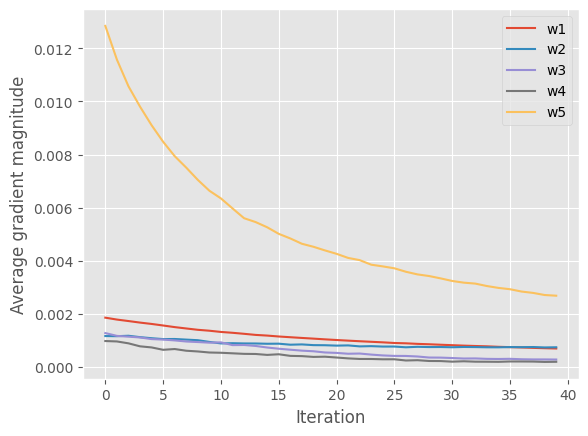

In [37]:
ax = plt.subplot(1,1,1)
plt.plot(abs(nn.grad_w1_[10:]), label='w1')
plt.plot(abs(nn.grad_w2_[10:]), label='w2')
plt.plot(abs(nn.grad_w3_[10:]), label='w3')
plt.plot(abs(nn.grad_w4_[10:]), label='w4')
plt.plot(abs(nn.grad_w5_[10:]), label='w5')
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

#### Implement an adaptive learning technique that was discussed in lecture and use it on the five layer network. Compare the performance of this model with and without the adaptive learning strategy. Do not use AdaM for the adaptive learning technique.

To further optimize our perceptron, lets implement an adaptive learning strategy to adjust the gradient based on the steepness. Here we used adaDelta, where we included calculations for the accumulated gradient and accumulated squared gradient. Later we will expand this technique with AdaM.

In [38]:
class FLAP(TwoLayerPerceptronBase):
    def __init__(self, n_hidden2=30, n_hidden3=25, n_hidden4=15, 
        adaptive=False, r=0.9,
        acc_grad1=0, acc_grad2=0, acc_grad3=0, acc_grad4=0, acc_grad5=0,
        acc_sq_grad1=0, acc_sq_grad2=0, acc_sq_grad3=0, acc_sq_grad4=0, acc_sq_grad5=0,
        **kwds):        
        # need to add to the original initializer 
        self.n_hidden2 = n_hidden2
        self.n_hidden3 = n_hidden3
        self.n_hidden4 = n_hidden4
        self.adaptive = adaptive
        self.r = r
        self.acc_grad1 = acc_grad1
        self.acc_grad2 = acc_grad2
        self.acc_grad3 = acc_grad3
        self.acc_grad4 = acc_grad4
        self.acc_grad5 = acc_grad5
        self.acc_sq_grad1 = acc_sq_grad1
        self.acc_sq_grad2 = acc_sq_grad2
        self.acc_sq_grad3 = acc_sq_grad3
        self.acc_sq_grad4 = acc_sq_grad4
        self.acc_sq_grad5 = acc_sq_grad5

        # but keep other keywords
        super().__init__(**kwds)
    
    def _initialize_weights(self):
        # initialize weights using Glorot implementation
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))

        init_bound = 4*np.sqrt(6. / (self.n_hidden2 + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden2, self.n_hidden))

        init_bound = 4*np.sqrt(6. / (self.n_hidden3 + self.n_hidden2))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden3, self.n_hidden2))

        init_bound = 4*np.sqrt(6. / (self.n_hidden4 + self.n_hidden3))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_hidden4, self.n_hidden3))
        
        # reduce the final layer magnitude in order to balance the size of the gradientes between
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden4))
        W5 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden4)) 

        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_hidden2, 1))
        b3 = np.zeros((self.n_hidden3, 1))
        b4 = np.zeros((self.n_hidden4, 1))
        b5 = np.zeros((self.n_output_, 1))
        
        return W1, W2, W3, W4, W5, b1, b2, b3, b4, b5

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4, W5):
        # Compute L2-regularization cost
        # only for non-bias terms
        means = np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:]**2) + np.mean(W4[:, 1:]**2) + np.mean(W5[:, 1:]**2)
        return (lambda_/2.0) * np.sqrt(means)

    def _cost(self, A6, Y_enc, W1, W2, W3, W4, W5):
        # get objective function value
        # cost = np.mean((Y_enc-A3)**2) # <- orignal cost function
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A6)+(1-Y_enc)*np.log(1-A6))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term

    def _feedforward(self, X, W1, W2, W3, W4, W5, b1, b2, b3, b4, b5):
        """ feedforward step:
        X: input layer with original features
        W1: Weight matrix for input layer -> hidden layer
        W2: Weight matrix for hidden layer1 -> hidden layer2
        W3: Weight matrix for hidden layer2 -> output layer

        a1-a3: activations into layer (or output layer)
        z1-z3: layer inputs
        """

        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        Z4 = W4 @ A4 + b4
        A5 = self._sigmoid(Z4)
        Z5 = W5 @ A5 + b5
        A6 = self._sigmoid(Z5)

        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6
    
    def _get_gradient(self, A1, A2, A3, A4, A5, A6, Z1, Z2, Z3, Z4, Z5, Y_enc, W1, W2, W3, W4, W5):
        # compute gradient using backpropagation
        # vectorized backpropagation
        # V is just here to separate the gradient equation for convenience
        
        V5 = (A6-Y_enc)
        V4 = A5*(1-A5)*(W5.T @ V5)
        V3 = A4*(1-A4)*(W4.T @ V4)
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)
#         V2 = (A3-Y_enc) # updated for cross entropy 
#         V1 = A2*(1-A2)*(W2.T @ V2) # gradient for 2nd layer is determined before first
        
        gradW5 = V5 @ A5.T
        gradW4 = V4 @ A4.T
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb5 = np.sum(V5, axis=1).reshape((-1,1)) 
        gradb4 = np.sum(V4, axis=1).reshape((-1,1)) 
        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))

        #regularize weights, not bias
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C
        gradW4 += W4 * self.l2_C
        gradW5 += W5 * self.l2_C

        return gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5

    def predict(self, X):
        # predict class labels
        if type(X) != np.ndarray:
            X = X.to_numpy()
        _, _, _, _, _, _, _, _, _, _, A6 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4, self.W5,
                                                        self.b1, self.b2, self.b3, self.b4, self.b5)
        y_pred = np.argmax(A6, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False, XY_test=None):
        # learn weights from training data
        X_data, y_data = X.copy(), y.copy()
        if type(X) != np.ndarray:
            X_data, y_data = X_data.to_numpy(), y_data.to_numpy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5, self.b1, self.b2, self.b3, self.b4, self.b5 = self._initialize_weights()  #initialize weights with random values

        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        self.grad_w4_ = np.zeros(self.epochs)
        self.grad_w5_ = np.zeros(self.epochs)
        
        mean_1 = []
        mean_2 = []
        mean_3 = []
        mean_4 = []
        mean_5 = []
        
        self.cost_ = []
        
        # adding support for keeping of validation in training loop
        # add in a calculation to test validation loss and accuracy at the end of each epoch
        self.score_ = [] 
        self.score_.append(accuracy_score(y_data, self.predict(X_data))) # get starting accuracy
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test, self.predict(X_test)))
            self.val_cost_ = []


        for i in range(self.epochs):
            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpochs: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:,idx_shuffle], y_data[idx_shuffle]

            # Use numpy split to split into equal sized batches
            # num batches == self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:
                # feedforward

                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data[idx], 
                                                                       self.W1, self.W2, self.W3, self.W4, self.W5,
                                                                       self.b1, self.b2, self.b3, self.b4, self.b5)

                cost = self._cost(A6, Y_enc[:, idx], self.W1, self.W2, self.W3, self.W4, self.W5)
                mini_cost.append(cost) # appends cost of mini-batch only
                #compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5= self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6,
                                                                                    Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                                                Y_enc=Y_enc[:, idx], W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4, W5=self.W5)
                
                mean_1.append(np.mean(gradW1))
                mean_2.append(np.mean(gradW2))
                mean_3.append(np.mean(gradW3))
                mean_4.append(np.mean(gradW4))
                mean_5.append(np.mean(gradW5))
                
                self.W1 -= self.eta * gradW1
                self.W2 -= self.eta * gradW2
                self.W3 -= self.eta * gradW3
                self.W4 -= self.eta * gradW4
                self.W5 -= self.eta * gradW5

                p1, p2, p3, p4, p5 = 0, 0, 0, 0, 0
                
                if (self.adaptive):
                    e = 10**-8

                    p1 = self.acc_grad1 / np.sqrt(self.acc_sq_grad1 + e)
                    p2 = self.acc_grad2 / np.sqrt(self.acc_sq_grad2 + e)
                    p3 = self.acc_grad3 / np.sqrt(self.acc_sq_grad3 + e)
                    p4 = self.acc_grad4 / np.sqrt(self.acc_sq_grad4 + e)
                    p5 = self.acc_grad5 / np.sqrt(self.acc_sq_grad5 + e)

                    self.acc_grad1 = self.r * self.acc_grad1 + (1 - self.r) * gradW1
                    self.acc_grad2 = self.r * self.acc_grad2 + (1 - self.r) * gradW2
                    self.acc_grad3 = self.r * self.acc_grad3 + (1 - self.r) * gradW3
                    self.acc_grad4 = self.r * self.acc_grad4 + (1 - self.r) * gradW4
                    self.acc_grad5 = self.r * self.acc_grad5 + (1 - self.r) * gradW5

                    self.acc_sq_grad1 = self.r * self.acc_sq_grad1 + (1 - self.r) * np.multiply(gradW1, gradW1)
                    self.acc_sq_grad2 = self.r * self.acc_sq_grad2 + (1 - self.r) * np.multiply(gradW2, gradW2)
                    self.acc_sq_grad3 = self.r * self.acc_sq_grad3 + (1 - self.r) * np.multiply(gradW3, gradW3)
                    self.acc_sq_grad4 = self.r * self.acc_sq_grad4 + (1 - self.r) * np.multiply(gradW4, gradW4)
                    self.acc_sq_grad5 = self.r * self.acc_sq_grad5 + (1 - self.r) * np.multiply(gradW5, gradW5)

                self.W1 = self.W1 - self.eta * p1
                self.W2 = self.W2 - self.eta * p2
                self.W3 = self.W3 - self.eta * p3
                self.W4 = self.W4 - self.eta * p4
                self.W5 = self.W5 - self.eta * p5
                
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2
                self.b3 -= self.eta * gradb3
                self.b4 -= self.eta * gradb4
                self.b5 -= self.eta * gradb5

            self.grad_w1_[i] = np.mean(mean_1)
            self.grad_w2_[i] = np.mean(mean_2)
            self.grad_w3_[i] = np.mean(mean_3)
            self.grad_w4_[i] = np.mean(mean_4)
            self.grad_w5_[i] = np.mean(mean_5)
                
            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data, self.predict(X_data)))
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
        
        return self

In [42]:
%%time
nn = FLAP(n_hidden=50, 
                        n_hidden2=30,
                        n_hidden3=30,
                        n_hidden4=30,
                        C=0.01, # l2 regularization term
                        epochs=50, # number of runthroughs 
                        eta=0.001, #initial learning rate/step size
                        adaptive=True,
                        random_state=123,
                        minibatches=len(X_train)/125, # minibatch size
                        shuffle=True)


nn.fit(X_train, y_train, print_progress=10,XY_test=(X_test,y_test))
y_hat = nn.predict(X_test)
print('\nAccuracy:', accuracy_score(y_test, y_hat))

Epochs: 50/50
Accuracy: 0.8643426842684269
CPU times: user 2min 7s, sys: 1min 36s, total: 3min 43s
Wall time: 5min 4s


Overall, the performance changed very slightly compared to without the adaptive learning technique (5 layer above). While the accuracy did increase, it was very negligible and not statistically impactful. Following is a graph showing the gradient magnitudes for each layer vs. the number of Epoch, where we see a very steady decrease in the gradient as time goes on.

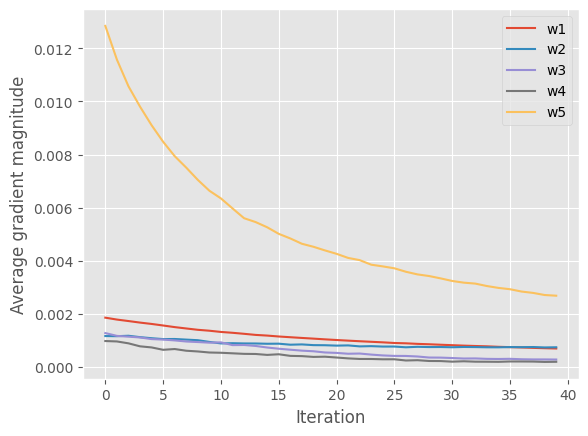

In [40]:
ax = plt.subplot(1,1,1)
plt.plot(abs(nn.grad_w1_[10:]), label='w1')
plt.plot(abs(nn.grad_w2_[10:]), label='w2')
plt.plot(abs(nn.grad_w3_[10:]), label='w3')
plt.plot(abs(nn.grad_w4_[10:]), label='w4')
plt.plot(abs(nn.grad_w5_[10:]), label='w5')
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

## Exceptional Work






 

Since we successfully implemented an adaptive learning technique, lets try to expand it with AdaM, which is the most popular adapative learning technique at the moment. The only difference here is that we boost the magnitudes of the accumulated gradient and accumulated squared gradient. We will continue to use our 5 layer perceptron with one-hot encoding and normalization of the data.

In [43]:
class AdaM(TwoLayerPerceptronBase):
    def __init__(self, n_hidden2=30, n_hidden3=25, n_hidden4=15, 
        adaptive=False, beta_1=0.9, beta_2=0.999, n=0.001,
        acc_grad1=0, acc_grad2=0, acc_grad3=0, acc_grad4=0, acc_grad5=0,
        acc_sq_grad1=0, acc_sq_grad2=0, acc_sq_grad3=0, acc_sq_grad4=0, acc_sq_grad5=0,
        **kwds):        
        # need to add to the original initializer 
        self.n_hidden2 = n_hidden2
        self.n_hidden3 = n_hidden3
        self.n_hidden4 = n_hidden4
        self.adaptive = adaptive
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.n = n
        self.acc_grad1 = acc_grad1
        self.acc_grad2 = acc_grad2
        self.acc_grad3 = acc_grad3
        self.acc_grad4 = acc_grad4
        self.acc_grad5 = acc_grad5
        self.acc_sq_grad1 = acc_sq_grad1
        self.acc_sq_grad2 = acc_sq_grad2
        self.acc_sq_grad3 = acc_sq_grad3
        self.acc_sq_grad4 = acc_sq_grad4
        self.acc_sq_grad5 = acc_sq_grad5

        # but keep other keywords
        super().__init__(**kwds)
    
    def _initialize_weights(self):
        # initialize weights using Glorot implementation
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))

        init_bound = 4*np.sqrt(6. / (self.n_hidden2 + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden2, self.n_hidden))

        init_bound = 4*np.sqrt(6. / (self.n_hidden3 + self.n_hidden2))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden3, self.n_hidden2))

        init_bound = 4*np.sqrt(6. / (self.n_hidden4 + self.n_hidden3))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_hidden4, self.n_hidden3))
        
        # reduce the final layer magnitude in order to balance the size of the gradientes between
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden4))
        W5 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden4)) 

        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_hidden2, 1))
        b3 = np.zeros((self.n_hidden3, 1))
        b4 = np.zeros((self.n_hidden4, 1))
        b5 = np.zeros((self.n_output_, 1))
        
        return W1, W2, W3, W4, W5, b1, b2, b3, b4, b5

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4, W5):
        # Compute L2-regularization cost
        # only for non-bias terms
        means = np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:]**2) + np.mean(W4[:, 1:]**2) + np.mean(W5[:, 1:]**2)
        return (lambda_/2.0) * np.sqrt(means)

    def _cost(self, A6, Y_enc, W1, W2, W3, W4, W5):
        # get objective function value
        # cost = np.mean((Y_enc-A3)**2) # <- orignal cost function
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A6)+(1-Y_enc)*np.log(1-A6))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term

    def _feedforward(self, X, W1, W2, W3, W4, W5, b1, b2, b3, b4, b5):
        """ feedforward step:
        X: input layer with original features
        W1: Weight matrix for input layer -> hidden layer
        W2: Weight matrix for hidden layer1 -> hidden layer2
        W3: Weight matrix for hidden layer2 -> output layer

        a1-a3: activations into layer (or output layer)
        z1-z3: layer inputs
        """

        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        Z4 = W4 @ A4 + b4
        A5 = self._sigmoid(Z4)
        Z5 = W5 @ A5 + b5
        A6 = self._sigmoid(Z5)

        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6
    
    def _get_gradient(self, A1, A2, A3, A4, A5, A6, Z1, Z2, Z3, Z4, Z5, Y_enc, W1, W2, W3, W4, W5):
        # compute gradient using backpropagation
        # vectorized backpropagation
        # V is just here to separate the gradient equation for convenience
        
        V5 = (A6-Y_enc)
        V4 = A5*(1-A5)*(W5.T @ V5)
        V3 = A4*(1-A4)*(W4.T @ V4)
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)
#       # updated for cross entropy 
#       # gradient for 2nd layer is determined before first
        
        gradW5 = V5 @ A5.T
        gradW4 = V4 @ A4.T
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb5 = np.sum(V5, axis=1).reshape((-1,1)) 
        gradb4 = np.sum(V4, axis=1).reshape((-1,1)) 
        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))

        #regularize weights, not bias
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C
        gradW4 += W4 * self.l2_C
        gradW5 += W5 * self.l2_C

        return gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5

    def predict(self, X):
        # predict class labels
        if type(X) != np.ndarray:
            X = X.to_numpy()
        _, _, _, _, _, _, _, _, _, _, A6 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4, self.W5,
                                                        self.b1, self.b2, self.b3, self.b4, self.b5)
        y_pred = np.argmax(A6, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False, XY_test=None):
        # learn weights from training data
        X_data, y_data = X.copy(), y.copy()
        if type(X) != np.ndarray:
            X_data, y_data = X_data.to_numpy(), y_data.to_numpy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5, self.b1, self.b2, self.b3, self.b4, self.b5 = self._initialize_weights()  #initialize weights with random values

        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        self.grad_w4_ = np.zeros(self.epochs)
        self.grad_w5_ = np.zeros(self.epochs)
        
        mean_1 = []
        mean_2 = []
        mean_3 = []
        mean_4 = []
        mean_5 = []
        
        self.cost_ = []
        
        # adding support for keeping of validation in training loop
        # add in a calculation to test validation loss and accuracy at the end of each epoch
        self.score_ = [] 
        self.score_.append(accuracy_score(y_data, self.predict(X_data))) # get starting accuracy
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test, self.predict(X_test)))
            self.val_cost_ = []


        for i in range(self.epochs):
            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpochs: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:,idx_shuffle], y_data[idx_shuffle]

            # Use numpy split to split into equal sized batches
            # num batches == self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            k = 1
            for idx in mini:
                # feedforward

                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data[idx], 
                                                                       self.W1, self.W2, self.W3, self.W4, self.W5,
                                                                       self.b1, self.b2, self.b3, self.b4, self.b5)

                cost = self._cost(A6, Y_enc[:, idx], self.W1, self.W2, self.W3, self.W4, self.W5)
                mini_cost.append(cost) # appends cost of mini-batch only
                #compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5= self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6,
                                                                                    Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                                                Y_enc=Y_enc[:, idx], W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4, W5=self.W5)
                
                mean_1.append(np.mean(gradW1))
                mean_2.append(np.mean(gradW2))
                mean_3.append(np.mean(gradW3))
                mean_4.append(np.mean(gradW4))
                mean_5.append(np.mean(gradW5))
                
                self.W1 -= self.eta * gradW1
                self.W2 -= self.eta * gradW2
                self.W3 -= self.eta * gradW3
                self.W4 -= self.eta * gradW4
                self.W5 -= self.eta * gradW5

                p1, p2, p3, p4, p5 = 0, 0, 0, 0, 0
                
                if (self.adaptive):
                    e = 10**-8

                    p1 = self.acc_grad1 / np.sqrt(self.acc_sq_grad1 + e)
                    p2 = self.acc_grad2 / np.sqrt(self.acc_sq_grad2 + e)
                    p3 = self.acc_grad3 / np.sqrt(self.acc_sq_grad3 + e)
                    p4 = self.acc_grad4 / np.sqrt(self.acc_sq_grad4 + e)
                    p5 = self.acc_grad5 / np.sqrt(self.acc_sq_grad5 + e)

                    self.acc_grad1 = self.beta_1 * self.acc_grad1 + (1 - self.beta_1) * gradW1
                    self.acc_grad2 = self.beta_1 * self.acc_grad2 + (1 - self.beta_1) * gradW2
                    self.acc_grad3 = self.beta_1 * self.acc_grad3 + (1 - self.beta_1) * gradW3
                    self.acc_grad4 = self.beta_1 * self.acc_grad4 + (1 - self.beta_1) * gradW4
                    self.acc_grad5 = self.beta_1 * self.acc_grad5 + (1 - self.beta_1) * gradW5

                    self.acc_grad1 = self.acc_grad1/(1-self.beta_1**k)
                    self.acc_grad2 = self.acc_grad2/(1-self.beta_1**k)
                    self.acc_grad3 = self.acc_grad3/(1-self.beta_1**k)
                    self.acc_grad4 = self.acc_grad4/(1-self.beta_1**k)
                    self.acc_grad5 = self.acc_grad5/(1-self.beta_1**k)

                    self.acc_sq_grad1 = self.beta_2 * self.acc_sq_grad1 + (1 - self.beta_2) * np.multiply(gradW1, gradW1)
                    self.acc_sq_grad2 = self.beta_2 * self.acc_sq_grad2 + (1 - self.beta_2) * np.multiply(gradW2, gradW2)
                    self.acc_sq_grad3 = self.beta_2 * self.acc_sq_grad3 + (1 - self.beta_2) * np.multiply(gradW3, gradW3)
                    self.acc_sq_grad4 = self.beta_2 * self.acc_sq_grad4 + (1 - self.beta_2) * np.multiply(gradW4, gradW4)
                    self.acc_sq_grad5 = self.beta_2 * self.acc_sq_grad5 + (1 - self.beta_2) * np.multiply(gradW5, gradW5)
                    
                    self.acc_sq_grad1 = self.acc_sq_grad1/(1-self.beta_2**k)
                    self.acc_sq_grad2 = self.acc_sq_grad2/(1-self.beta_2**k)
                    self.acc_sq_grad3 = self.acc_sq_grad3/(1-self.beta_2**k)
                    self.acc_sq_grad4 = self.acc_sq_grad4/(1-self.beta_2**k)
                    self.acc_sq_grad5 = self.acc_sq_grad5/(1-self.beta_2**k)

                    k+=1

                self.W1 = self.W1 - self.eta * p1
                self.W2 = self.W2 - self.eta * p2
                self.W3 = self.W3 - self.eta * p3
                self.W4 = self.W4 - self.eta * p4
                self.W5 = self.W5 - self.eta * p5
                
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2
                self.b3 -= self.eta * gradb3
                self.b4 -= self.eta * gradb4
                self.b5 -= self.eta * gradb5

            self.grad_w1_[i] = np.mean(mean_1)
            self.grad_w2_[i] = np.mean(mean_2)
            self.grad_w3_[i] = np.mean(mean_3)
            self.grad_w4_[i] = np.mean(mean_4)
            self.grad_w5_[i] = np.mean(mean_5)
                
            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data, self.predict(X_data)))
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
        
        return self

In [46]:
%%time
nn = AdaM(n_hidden=50, 
            n_hidden2=30,
            n_hidden3=30,
            n_hidden4=30,
            C=0.01, # l2 regularization term
            epochs=50, # number of runthroughs 
            eta=0.001, #initial learning rate/step size
            adaptive=True,
            random_state=123,
            minibatches=len(X_train)/125, # minibatch size
            shuffle=True)


nn.fit(X_train, y_train, print_progress=10,XY_test=(X_test,y_test))
y_hat = nn.predict(X_test)
print('\nAccuracy:', accuracy_score(y_test, y_hat))

/tmp/ipykernel_752/4176885033.py:249: RuntimeWarning: overflow encountered in divide
  self.acc_sq_grad5 = self.acc_sq_grad5/(1-self.beta_2**k)
/tmp/ipykernel_752/4176885033.py:248: RuntimeWarning: overflow encountered in divide
  self.acc_sq_grad4 = self.acc_sq_grad4/(1-self.beta_2**k)
/tmp/ipykernel_752/4176885033.py:247: RuntimeWarning: overflow encountered in divide
  self.acc_sq_grad3 = self.acc_sq_grad3/(1-self.beta_2**k)
/tmp/ipykernel_752/4176885033.py:246: RuntimeWarning: overflow encountered in divide
  self.acc_sq_grad2 = self.acc_sq_grad2/(1-self.beta_2**k)
/tmp/ipykernel_752/4176885033.py:245: RuntimeWarning: overflow encountered in divide
  self.acc_sq_grad1 = self.acc_sq_grad1/(1-self.beta_2**k)
Epochs: 50/50
Accuracy: 0.8624862486248625
CPU times: user 2min 15s, sys: 1min 43s, total: 3min 58s
Wall time: 5min 24s


As expected, the accuracy increased slightly, but with the cost of a slightly increased speed. As discussed in class, the performances of these the lasted optimization technique are very negligible. Here is the graph of the gradient magnitude vs. the number of Epochs, which should be similar to the previous optimization technique.

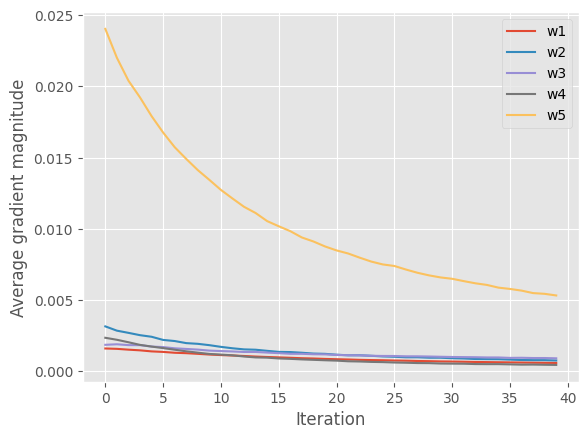

In [47]:
ax = plt.subplot(1,1,1)
plt.plot(abs(nn.grad_w1_[10:]), label='w1')
plt.plot(abs(nn.grad_w2_[10:]), label='w2')
plt.plot(abs(nn.grad_w3_[10:]), label='w3')
plt.plot(abs(nn.grad_w4_[10:]), label='w4')
plt.plot(abs(nn.grad_w5_[10:]), label='w5')
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c5637e4b-5c94-4c73-808b-46de406a57af' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>